In [ ]:
pip install openai sentence-transformers scikit-learn numpy matplotlib hdbscan umap-learn tensorflow

2024-05-17 16:51:21.469275: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 16:51:21.470163: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 16:51:21.474608: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 16:51:21.527877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 16:51:22.846566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch 1/10


2024-05-17 16:56:26.453675: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2533
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2532
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2531
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2529
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2527
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2523
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2518
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2511
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2501
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2482


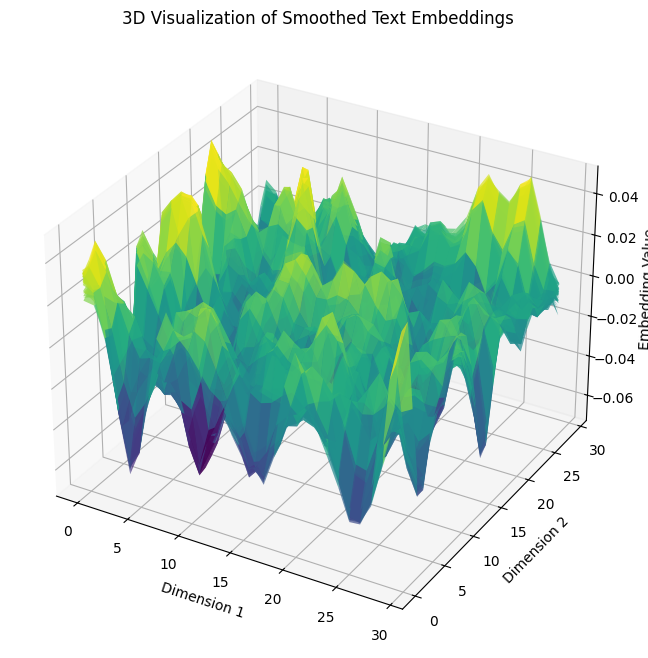

In [1]:
import openai
import numpy as np
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Initialize OpenAI client
client = openai.OpenAI(api_key="sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP")
MODEL = "gpt-4o"

# Function to get responses from GPT-4o
def get_responses(prompt, n, max_tokens=1000, temperature=0.7, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    responses = []
    log_probs = []
    for _ in range(n):
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
            logprobs=True
        )
        responses.append(response.choices[0].message.content)
        log_probs.append(response.choices[0].logprobs)
    return responses, log_probs

# Function to get embeddings for the responses
def get_embeddings(responses):
    model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
    embeddings = model.encode(responses)
    return embeddings

# Function to convert log probabilities to probabilities using softmax
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits / exp_logits.sum()

def analyze_log_probs(log_probs):
    probability_map = []
    for choice in log_probs:
        # Access the 'content' attribute which is the list of 'ChatCompletionTokenLogprob'
        tokens = [token_logprob.token for token_logprob in choice.content]
        token_logprobs = [token_logprob.logprob for token_logprob in choice.content]

        # Convert log probabilities to probabilities using softmax
        token_probs = softmax(token_logprobs)

        probability_map.append({
            'tokens': tokens,
            'token_probs': token_probs,
            'token_logprobs': token_logprobs  # Store raw log probabilities for plotting
        })
    
    return probability_map

# Function to train an autoencoder
def train_autoencoder(input_data, latent_dim):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
    encoded = tf.keras.layers.Dropout(0.5)(encoded)
    encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    autoencoder_input = encoder_input
    encoded_embedding = encoder(autoencoder_input)
    decoded_embedding = decoder(encoded_embedding)

    autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

    autoencoder.fit(input_data, input_data, epochs=10, batch_size=16, verbose=1)
    return encoder

# Function to visualize 2D grid in 3D with smoothing
def visualize_2d_grid(encoded_2d_grid, grid_size):
    smoothed_grids = np.array([gaussian_filter(grid, sigma=1) for grid in encoded_2d_grid])

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i]
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')
    plt.show()

def extract_token_probs(data):
    # Initialize an empty list to store the token probabilities
    token_probs_list = []
    
    # Iterate over each entry in the data list
    for entry in data:
        # Check if 'token_probs' key exists in the dictionary
        if 'token_probs' in entry:
            # Append the numpy array of token probabilities to the list
            token_probs_list.append(entry['token_probs'])
    
    # Return the list of token probabilities
    return token_probs_list
    
def pad_token_probs(probabilities, pad_value=0):
    # Find the maximum length of the token probabilities list
    max_length = max(len(probs) for probs in probabilities)
    # Pad each probabilities list to the maximum length
    padded_probabilities = np.array([np.pad(probs, (0, max_length - len(probs)), 'constant', constant_values=pad_value) for probs in probabilities])
    return padded_probabilities


prompt = "I want a script that generates an analysis of some text data. Pull the text data from any source of text it doesn't matter what."
n = 20
responses, log_probs = get_responses(prompt, n)
embeddings = get_embeddings(responses)

probability_map = analyze_log_probs(log_probs)
token_probs_list = extract_token_probs(probability_map)

token_probabilities = pad_token_probs([entry['token_probs'] for entry in probability_map])

# Combine embeddings and token probabilities
combined_input = np.hstack((embeddings, token_probabilities))

grid_size = 30
latent_dim = grid_size * grid_size
encoder = train_autoencoder(combined_input, latent_dim)

encoded_2d_grid = encoder(combined_input).numpy().reshape(-1, grid_size, grid_size)
visualize_2d_grid(encoded_2d_grid, grid_size)


In [ ]:
# Function to pad the token probabilities to the same length
def pad_token_probs(probabilities, pad_value=0):
    # Find the maximum length of the token probabilities list
    max_length = max(len(probs) for probs in probabilities)
    # Pad each probabilities list to the maximum length
    padded_probabilities = np.array([np.pad(probs, (0, max_length - len(probs)), 'constant', constant_values=pad_value) for probs in probabilities])
    return padded_probabilities

# Usage in your main workflow
token_probabilities = pad_token_probs([entry['token_probs'] for entry in probability_map])

combined_input = np.hstack((embeddings, token_probabilities))

In [ ]:
def train_autoencoder(input_data, latent_dim):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
    encoded = tf.keras.layers.Dropout(0.5)(encoded)
    encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    autoencoder_input = encoder_input
    encoded_embedding = encoder(autoencoder_input)
    decoded_embedding = decoder(encoded_embedding)

    autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

    autoencoder.fit(input_data, input_data, epochs=50, batch_size=16, verbose=1)
    return encoder
# Function to visualize 2D grid in 3D with smoothing
def visualize_2d_grid(encoded_2d_grid, grid_size):
    smoothed_grids = np.array([gaussian_filter(grid, sigma=5) for grid in encoded_2d_grid])

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i]
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')
    plt.show()
grid_size = 100
latent_dim = grid_size * grid_size
encoder = train_autoencoder(combined_input, latent_dim)
encoded_2d_grid = encoder(combined_input).numpy().reshape(-1, grid_size, grid_size)
visualize_2d_grid(encoded_2d_grid, grid_size)

In [ ]:
import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def multi_layer_pool(hidden_states: list, attention_mask: Tensor, num_layers: int = 4) -> Tensor:
    # Extract embeddings from the last 'num_layers' layers and concatenate them
    all_layers = hidden_states[-num_layers:]  # Get the last num_layers layers
    concatenated_layers = torch.cat(all_layers, dim=-1)  # Concatenate them on the embedding dimension

    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return concatenated_layers[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = concatenated_layers.shape[0]
        return concatenated_layers[torch.arange(batch_size, device=concatenated_layers.device), sequence_lengths]


def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'


# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'
queries = [
    get_detailed_instruct(task, 'how much protein should a female eat'),
    get_detailed_instruct(task, 'summit define')
]
# No need to add instruction for retrieval documents
documents = [
    "As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
    "Definition of summit for English Language Learners. : 1  the highest point of a mountain : the top of a mountain. : 2  the highest level. : 3  a meeting or series of meetings between the leaders of two or more governments."
]
input_texts = queries + documents

tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained('intfloat/e5-mistral-7b-instruct')

max_length = 4096
# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')

# Set output_hidden_states to True
outputs = model(**batch_dict, output_hidden_states=True)
# Use the new pooling method
embeddings = multi_layer_pool(outputs.hidden_states, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T) * 100
print(scores.tolist())


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################


In [ ]:
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################


In [ ]:
import openai
import numpy as np
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Initialize OpenAI client
client = openai.OpenAI(api_key="sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP")
MODEL = "gpt-4o"

# Function to get responses from GPT-4o
def get_responses(prompt, n, max_tokens=100, temperature=0.7, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    responses = []
    log_probs = []
    for _ in range(n):
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
            logprobs=True
        )
        responses.append(response.choices[0].message.content)
        log_probs.append(response.choices[0].logprobs)
    return responses, log_probs

# Function to get embeddings for the responses
def get_embeddings(responses):
    model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
    embeddings = model.encode(responses)
    return embeddings

# Function to convert log probabilities to probabilities using softmax
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits / exp_logits.sum()

def analyze_log_probs(log_probs):
    probability_map = []
    for choice in log_probs:
        tokens = [token_logprob.token for token_logprob in choice.content]
        token_logprobs = [token_logprob.logprob for token_logprob in choice.content]
        token_probs = softmax(token_logprobs)
        probability_map.append({
            'tokens': tokens,
            'token_probs': token_probs,
            'token_logprobs': token_logprobs
        })
    return probability_map

# Function to train an autoencoder
def train_autoencoder(input_data, latent_dim):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
    encoded = tf.keras.layers.Dropout(0.5)(encoded)
    encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)
    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')
    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)
    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')
    autoencoder_input = encoder_input
    encoded_embedding = encoder(autoencoder_input)
    decoded_embedding = decoder(encoded_embedding)
    autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
    autoencoder.fit(input_data, input_data, epochs=20, batch_size=8, verbose=1)
    return encoder

# Function to visualize 2D grid in 3D with smoothing
def visualize_2d_grid(encoded_2d_grid, grid_size):
    smoothed_grids = np.array([gaussian_filter(grid, sigma=1) for grid in encoded_2d_grid])
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i]
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')
    plt.show()

# Main function to orchestrate the workflow
def main():
    prompt = "make me a short unique poem about aliens fighting on venus over earths iranian goat population gaining sentience"
    n = 20
    responses, log_probs = get_responses(prompt, n)
    embeddings = get_embeddings(responses)
    probability_map = analyze_log_probs(log_probs)
    token_probs_list = np.array([entry['token_probs'] for entry in probability_map])
    combined_input = np.hstack((embeddings, token_probs_list))
    grid_size = 30
    latent_dim = grid_size * grid_size
    encoder = train_autoencoder(combined_input, latent_dim)
    encoded_2d_grid = encoder(combined_input).numpy().reshape(-1, grid_size, grid_size)
    visualize_2d_grid(encoded_2d_grid, grid_size)

if __name__ == "__main__":
    main()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the Text
sample_text = "Natural language processing (NLP) involves the interaction between computers and humans through language. It enables machines to read, understand, and derive meaning from human languages."

# Step 2: Vectorize the Text using Universal Sentence Encoder from TensorFlow Hub
# Load Universal Sentence Encoder
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

# Convert the sample text into an embedding
text_embedding = embedding_layer([sample_text])
print("Original Embedding Shape:", text_embedding.shape)

# Step 3: Build and Train an Autoencoder Model to reduce dimensionality to a 2D array
# Define the encoder model
encoder_input = tf.keras.Input(shape=(text_embedding.shape[-1],))
encoded = tf.keras.layers.Dense(128, activation='relu')(encoder_input)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
encoded_output = tf.keras.layers.Dense(2 * 2, activation='linear')(encoded)  # 2x2 array output

encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

# Define the decoder model
decoder_input = tf.keras.Input(shape=(2 * 2,))
decoded = tf.keras.layers.Dense(32, activation='relu')(decoder_input)
decoded = tf.keras.layers.Dense(64, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded_output = tf.keras.layers.Dense(text_embedding.shape[-1], activation='sigmoid')(decoded)

decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

# Combine encoder and decoder into an autoencoder model
autoencoder_input = encoder_input
encoded_embedding = encoder(autoencoder_input)
decoded_embedding = decoder(encoded_embedding)

autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
# Here, we use the text embedding itself as the target (autoencoder learns to reconstruct its input)
autoencoder.fit(text_embedding, text_embedding, epochs=100, batch_size=1, verbose=0)

# Predict the 2D coordinates
encoded_2d_array = encoder(text_embedding)
print("2D Array for the Input Text:", encoded_2d_array.numpy().reshape(2, 2))

# Step 4: Visualize the 2D Array Result
encoded_2d_array_reshaped = encoded_2d_array.numpy().reshape(2, 2)

plt.figure(figsize=(6, 6))
plt.imshow(encoded_2d_array_reshaped, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('2D Array Embedding of the Text')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_20newsgroups

# Step 1: Prepare Multiple Text Samples
newsgroups = fetch_20newsgroups(subset='train')
texts = newsgroups.data[:1000]  # Limit to 1000 samples for this example

# Step 2: Convert Text Samples into Embeddings using Universal Sentence Encoder
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

text_embeddings = embedding_layer(texts)
print("Original Embedding Shape:", text_embeddings.shape)

# Step 3: Build and Train an Autoencoder to reduce dimensionality to a large 2D grid
grid_size = 30  # 30x30 grid
latent_dim = grid_size * grid_size

# Define the encoder model
encoder_input = tf.keras.Input(shape=(text_embeddings.shape[-1],))
encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)  # Larger 2D grid output

encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

# Define the decoder model
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded_output = tf.keras.layers.Dense(text_embeddings.shape[-1], activation='sigmoid')(decoded)

decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

# Combine encoder and decoder into an autoencoder model
autoencoder_input = encoder_input
encoded_embedding = encoder(autoencoder_input)
decoded_embedding = decoder(encoded_embedding)

autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(text_embeddings, text_embeddings, epochs=50, batch_size=32, verbose=1)

# Step 4: Visualize the 2D Grid in 3D
encoded_2d_grid = encoder(text_embeddings).numpy().reshape(-1, grid_size, grid_size)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(grid_size), range(grid_size))
for i in range(encoded_2d_grid.shape[0]):
    Z = encoded_2d_grid[i]
    ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_title('3D Visualization of Text Embeddings')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Embedding Value')
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_20newsgroups
from scipy.ndimage import gaussian_filter

# Step 1: Prepare Multiple Text Samples
newsgroups = fetch_20newsgroups(subset='train')
texts = newsgroups.data[:1000]  # Limit to 1000 samples for this example

# Step 2: Convert Text Samples into Embeddings using Universal Sentence Encoder
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

text_embeddings = embedding_layer(texts)
print("Original Embedding Shape:", text_embeddings.shape)

# Step 3: Build and Train an Autoencoder to reduce dimensionality to a large 2D grid
grid_size = 30  # 30x30 grid
latent_dim = grid_size * grid_size

# Define the encoder model
encoder_input = tf.keras.Input(shape=(text_embeddings.shape[-1],))
encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)  # Larger 2D grid output

encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

# Define the decoder model
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded_output = tf.keras.layers.Dense(text_embeddings.shape[-1], activation='sigmoid')(decoded)

decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

# Combine encoder and decoder into an autoencoder model
autoencoder_input = encoder_input
encoded_embedding = encoder(autoencoder_input)
decoded_embedding = decoder(encoded_embedding)

autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(text_embeddings, text_embeddings, epochs=50, batch_size=32, verbose=1)

# Step 4: Visualize the 2D Grid in 3D with Smoothing
encoded_2d_grid = encoder(text_embeddings).numpy().reshape(-1, grid_size, grid_size)

# Apply Gaussian smoothing to each sample's 2D grid
smoothed_grids = np.array([gaussian_filter(grid, sigma=1) for grid in encoded_2d_grid])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(grid_size), range(grid_size))
for i in range(smoothed_grids.shape[0]):
    Z = smoothed_grids[i]
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

ax.set_title('3D Visualization of Smoothed Text Embeddings')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Embedding Value')
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_20newsgroups
from scipy.ndimage import gaussian_filter

# Step 1: Prepare Multiple Text Samples
newsgroups = fetch_20newsgroups(subset='train')
texts = newsgroups.data[:1000]  # Limit to 1000 samples for this example

# Step 2: Convert Text Samples into Embeddings using Universal Sentence Encoder
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

text_embeddings = embedding_layer(texts)
print("Original Embedding Shape:", text_embeddings.shape)

# Step 3: Build and Train an Autoencoder to reduce dimensionality to a large 2D grid
grid_size = 30  # 30x30 grid
latent_dim = grid_size * grid_size

encoder_input = tf.keras.Input(shape=(text_embeddings.shape[-1],))
encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
encoded = tf.keras.layers.Dropout(0.5)(encoded)  # Adding dropout
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

# Define the decoder model
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded_output = tf.keras.layers.Dense(text_embeddings.shape[-1], activation='sigmoid')(decoded)

decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

# Combine encoder and decoder into an autoencoder model
autoencoder_input = encoder_input
encoded_embedding = encoder(autoencoder_input)
decoded_embedding = decoder(encoded_embedding)

autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

autoencoder.fit(text_embeddings, text_embeddings, epochs=10, batch_size=16, verbose=1)

# Step 4: Visualize the 2D Grid in 3D with Smoothing
encoded_2d_grid = encoder(text_embeddings).numpy().reshape(-1, grid_size, grid_size)

# Apply Gaussian smoothing to each sample's 2D grid
smoothed_grids = np.array([gaussian_filter(grid, sigma=1) for grid in encoded_2d_grid])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(grid_size), range(grid_size))
for i in range(smoothed_grids.shape[0]):
    Z = smoothed_grids[i]
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

ax.set_title('3D Visualization of Smoothed Text Embeddings')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Embedding Value')
plt.show()


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_20newsgroups
from scipy.ndimage import gaussian_filter

# Step 1: Prepare Multiple Text Samples
newsgroups = fetch_20newsgroups(subset='train')
texts = newsgroups.data[:10]  # Limit to 1000 samples for this example

# Step 2: Convert Text Samples into Embeddings using Universal Sentence Encoder
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", input_shape=[], dtype=tf.string, trainable=False)

text_embeddings = embedding_layer(texts)
print("Original Embedding Shape:", text_embeddings.shape)

# Step 3: Build and Train an Autoencoder to reduce dimensionality to a large 2D grid
grid_size = 10  # 30x30 grid
latent_dim = grid_size * grid_size

# Define the encoder model
encoder_input = tf.keras.Input(shape=(text_embeddings.shape[-1],))
encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)  # Larger 2D grid output

encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

# Define the decoder model
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded_output = tf.keras.layers.Dense(text_embeddings.shape[-1], activation='sigmoid')(decoded)

decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

# Combine encoder and decoder into an autoencoder model
autoencoder_input = encoder_input
encoded_embedding = encoder(autoencoder_input)
decoded_embedding = decoder(encoded_embedding)

autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(text_embeddings, text_embeddings, epochs=10, batch_size=16, verbose=1)

# Step 4: Visualize the 2D Grid in 3D with Smoothing
encoded_2d_grid = encoder(text_embeddings).numpy().reshape(-1, grid_size, grid_size)

# Apply Gaussian smoothing to each sample's 2D grid
smoothed_grids = np.array([gaussian_filter(grid, sigma=5) for grid in encoded_2d_grid])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(grid_size), range(grid_size))
for i in range(smoothed_grids.shape[0]):
    Z = smoothed_grids[i]
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

ax.set_title('3D Visualization of Smoothed Text Embeddings')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Embedding Value')
plt.show()


In [ ]:
pip install openai sentence-transformers scikit-learn numpy matplotlib hdbscan umap-learn


In [ ]:
import openai
import os
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import umap
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans

client = openai.OpenAI(api_key="sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP")
MODEL = "gpt-4o"

# Function to get responses from GPT-4o
def get_responses(prompt, n, max_tokens=100, temperature=0.7, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    responses = []
    log_probs = []
    for _ in range(n):
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
            logprobs=True
        )
        responses.append(response.choices[0].message.content)
        log_probs.append(response.choices[0].logprobs)
    return responses, log_probs


# Function to get embeddings for the responses
def get_embeddings(responses):
    model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
    embeddings = model.encode(responses)
    return embeddings

# Function to cluster embeddings (HDBSCAN or K-Means)
def cluster_embeddings(embeddings, method='hdbscan'):
    if method == 'hdbscan':
        clusterer = HDBSCAN(min_cluster_size=15, cluster_selection_method='leaf')
        cluster_labels = clusterer.fit_predict(embeddings)
    else:
        clusterer = KMeans(n_clusters=5)
        cluster_labels = clusterer.fit_predict(embeddings)
    return cluster_labels

# Function to visualize embeddings using UMAP
def visualize_embeddings(embeddings, labels):
    n_neighbors = min(15, len(embeddings) - 1)
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors)
    reduced_embeddings = reducer.fit_transform(embeddings)
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='Spectral')
    plt.colorbar()
    plt.show()

def plot_raw_logits(probability_map):
    for entry in probability_map:
        tokens = entry['tokens']
        log_probs = entry['token_logprobs']  # Assuming this key will be added to the dictionary
        
        # Ensure we have valid data
        if tokens and log_probs and len(tokens) == len(log_probs):
            plt.figure(figsize=(10, 5))
            plt.bar(tokens, log_probs)
            plt.xlabel('Tokens')
            plt.ylabel('Log Probabilities')
            plt.title('Raw Log Probabilities of Tokens')
            plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
            plt.show()


def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits / exp_logits.sum()

def analyze_log_probs(log_probs):
    probability_map = []
    for choice in log_probs:
        # Access the 'content' attribute which is the list of 'ChatCompletionTokenLogprob'
        tokens = [token_logprob.token for token_logprob in choice.content]
        token_logprobs = [token_logprob.logprob for token_logprob in choice.content]

        # Convert log probabilities to probabilities using softmax
        token_probs = softmax(token_logprobs)

        probability_map.append({
            'tokens': tokens,
            'token_probs': token_probs,
            'token_logprobs': token_logprobs  # Store raw log probabilities for plotting
        })
    
    return probability_map

def plot_probabilities(probability_map):
    for entry in probability_map:
        tokens = entry['tokens']
        token_probs = entry['token_probs']
        
        # Ensure we have valid data
        if tokens and token_probs is not None and len(tokens) == len(token_probs):
            plt.figure(figsize=(10, 5))
            plt.bar(tokens, token_probs)
            plt.xlabel('Tokens')
            plt.ylabel('Probabilities')
            plt.title('Token Probabilities')
            plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
            plt.show()


# Main function to orchestrate the workflow
def main():
    prompt = "make me a short unique poem about aliens fighting on venus over earths iranian goat population gaining sentience"
    n = 10
    
    responses, log_probs = get_responses(
    prompt=prompt,
    n=5,
    max_tokens=100,
    temperature=2,
    top_p=0.3,
    frequency_penalty=0.1,
    presence_penalty=0.3
    )

    embeddings = get_embeddings(responses)
    
    # Choose clustering method ('hdbscan' or 'kmeans')
    clustering_method = 'hdbscan'
    cluster_labels = cluster_embeddings(embeddings, method=clustering_method)
    
    #print("Clustering Results:")
    #for i, response in enumerate(responses):
        #print(f"Cluster {cluster_labels[i]}: {response}")
    
    visualize_embeddings(embeddings, cluster_labels)

    print(log_probs)
    
    probability_map = analyze_log_probs(log_probs)
    print(probability_map)
    plot_probabilities(probability_map)
    plot_raw_logits(probability_map)

if __name__ == "__main__":
    main()


In [ ]:
import openai
import numpy as np
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Initialize OpenAI client
client = openai.OpenAI(api_key="sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP")
MODEL = "gpt-4o"

# Function to get responses from GPT-4o
def get_responses(prompt, n, max_tokens=100, temperature=0.7, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    responses = []
    log_probs = []
    for _ in range(n):
        response = client.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            frequency_penalty=frequency_penalty,
            presence_penalty=presence_penalty,
            logprobs=True
        )
        responses.append(response.choices[0].message.content)
        log_probs.append(response.choices[0].logprobs)
    return responses, log_probs

# Function to get embeddings for the responses
def get_embeddings(responses):
    model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')
    embeddings = model.encode(responses)
    return embeddings

# Function to convert log probabilities to probabilities using softmax
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))
    return exp_logits / exp_logits.sum()

def analyze_log_probs(log_probs):
    probability_map = []
    for choice in log_probs:
        # Access the 'content' attribute which is the list of 'ChatCompletionTokenLogprob'
        tokens = [token_logprob.token for token_logprob in choice.content]
        token_logprobs = [token_logprob.logprob for token_logprob in choice.content]

        # Convert log probabilities to probabilities using softmax
        token_probs = softmax(token_logprobs)

        probability_map.append({
            'tokens': tokens,
            'token_probs': token_probs,
            'token_logprobs': token_logprobs  # Store raw log probabilities for plotting
        })
    
    return probability_map

# Function to train an autoencoder
def train_autoencoder(input_data, latent_dim):
    encoder_input = tf.keras.Input(shape=(input_data.shape[-1],))
    encoded = tf.keras.layers.Dense(512, activation='relu')(encoder_input)
    encoded = tf.keras.layers.Dropout(0.5)(encoded)
    encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    encoded_output = tf.keras.layers.Dense(latent_dim, activation='linear')(encoded)

    encoder = tf.keras.Model(encoder_input, encoded_output, name='encoder')

    decoder_input = tf.keras.Input(shape=(latent_dim,))
    decoded = tf.keras.layers.Dense(128, activation='relu')(decoder_input)
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
    decoded_output = tf.keras.layers.Dense(input_data.shape[-1], activation='sigmoid')(decoded)

    decoder = tf.keras.Model(decoder_input, decoded_output, name='decoder')

    autoencoder_input = encoder_input
    encoded_embedding = encoder(autoencoder_input)
    decoded_embedding = decoder(encoded_embedding)

    autoencoder = tf.keras.Model(autoencoder_input, decoded_embedding, name='autoencoder')
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

    autoencoder.fit(input_data, input_data, epochs=10, batch_size=16, verbose=1)
    return encoder

# Function to visualize 2D grid in 3D with smoothing
def visualize_2d_grid(encoded_2d_grid, grid_size):
    smoothed_grids = np.array([gaussian_filter(grid, sigma=1) for grid in encoded_2d_grid])

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(range(grid_size), range(grid_size))
    for i in range(smoothed_grids.shape[0]):
        Z = smoothed_grids[i]
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    ax.set_title('3D Visualization of Smoothed Text Embeddings')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Embedding Value')
    plt.show()

def extract_token_probs(data):
    # Initialize an empty list to store the token probabilities
    token_probs_list = []
    
    # Iterate over each entry in the data list
    for entry in data:
        # Check if 'token_probs' key exists in the dictionary
        if 'token_probs' in entry:
            # Append the numpy array of token probabilities to the list
            token_probs_list.append(entry['token_probs'])
    
    # Return the list of token probabilities
    return token_probs_list

# Main function to orchestrate the workflow
def main():
    prompt = "make me a short unique poem about aliens fighting on venus over earths iranian goat population gaining sentience"
    n = 1
    responses, log_probs = get_responses(prompt, n)
    embeddings = get_embeddings(responses)

    probability_map = analyze_log_probs(log_probs)
    token_probs_list = extract_token_probs(probability_map)
    
    # Extract token probabilities from the probability map
    token_probabilities = np.array([entry['token_probs'] for entry in probability_map])
    
    # Combine embeddings and token probabilities
    combined_input = np.hstack((embeddings, token_probabilities))

    grid_size = 30
    latent_dim = grid_size * grid_size
    encoder = train_autoencoder(combined_input, latent_dim)

    encoded_2d_grid = encoder(combined_input).numpy().reshape(-1, grid_size, grid_size)
    visualize_2d_grid(encoded_2d_grid, grid_size)

if __name__ == "__main__":
    main()
